works
{'MIDIproba': 5}
{'MIDIproba': 5}
loading


endload
(array([[-0.38791589, -0.39054362, -0.40326308, ..., -0.83009381,
        -0.82405143, -0.82166575],
       [-0.43752088, -0.44500642, -0.46452335, ..., -0.85450532,
        -0.84144166, -0.83601759],
       [-0.34441999, -0.34274829, -0.34546639, ..., -0.86688967,
        -0.86276686, -0.86151599],
       ...,
       [-1.        , -1.        , -0.86164483, ..., -1.        ,
        -1.        , -1.        ],
       [-1.        , -1.        , -0.97933531, ..., -1.        ,
        -1.        , -1.        ],
       [-1.        , -1.        , -0.99198126, ..., -1.        ,
        -1.        , -1.        ]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]))


RuntimeError: Requested MovieWriter (ffmpeg) not available

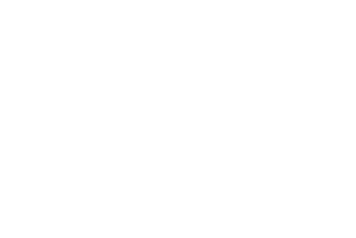

In [10]:
import random
import json
import os
import warnings

from IPython.display import display, Audio
import librosa
import matplotlib.pyplot as plt
import mir_eval
import mir_eval.display
import numpy as np
from keras.layers import LSTM, Activation, Convolution1D, Dense, TimeDistributed
from keras.models import Sequential
from keras.preprocessing import sequence
import pretty_midi

warnings.filterwarnings(
    'ignore')  # TODO Remove when librosa.cqt has been updated.

DATA_PATH = '.'
RESULTS_PATH = '.'
SCORE_FILE = 'match_scores.json'


def msd_path(msd_id):
    """Given an MSD ID, generate the path prefix.
    E.g. TRABCD12345678 -> A/B/C/TRABCD12345678"""
    return os.path.join(msd_id[2], msd_id[3], msd_id[4], msd_id)


def mp3_path(msd_id):
    """Given an MSD ID, return the path to the corresponding MP3 file."""
    return os.path.join(DATA_PATH, msd_id + '.wav')


def midi_path(msd_id, midi_md5, kind='aligned'):
    """Given an MSD ID and MIDI MD5, return path to a MIDI file."""
    # TODO Enums kind: 'matched' or 'aligned'
    return os.path.join(RESULTS_PATH, msd_id + '.mid')
import traceback
print("works")


from scipy.misc import imresize
with open(SCORE_FILE) as f:
    scores = json.load(f)

def load(msd_id, matches):
    try:
        print("loading")
        # Compute constant-Q spectrogram.
        audio, fs = librosa.load(mp3_path(msd_id), sr=None)
        cqt = librosa.core.amplitude_to_db(librosa.cqt(audio)) # , real=False
        cqt = librosa.util.normalize(cqt)
        
        # TODO Synthesize MIDI. We could use this for the Lakh MIDI files without 7digital preview MP3s.
        #midi_audio = pm.fluidsynth(fs)
        #display(Audio(midi_audio, rate=fs))
        
        # Average existing MIDI annotations for the audio into a single matrix.
        piano_roll = None
        #midi_md5 = max(matches, key=lambda x: x[1])
        """
        for midi_md5, score in matches.items():
            pm = pretty_midi.PrettyMIDI(midi_path(msd_id, midi_md5, 'aligned'))
            x = pm.get_piano_roll()
            if x.shape[1] > 0:
                if piano_roll is not None:
                    x = imresize(x, size=piano_roll.shape)
                    piano_roll = np.dstack((piano_roll, x))
                else:
                    piano_roll = pm.get_piano_roll()[..., np.newaxis]
        """
        pm = pretty_midi.PrettyMIDI(midi_path(msd_id, 'asd', 'aligned'))
        piano_roll = pm.get_piano_roll()[..., np.newaxis]
        piano_roll = np.average(piano_roll, axis=2)
        
        # Use 7 octaves starting from C1.
        piano_roll = piano_roll[12:96]
        piano_roll = imresize(piano_roll, size=cqt.shape)
        piano_roll = piano_roll.astype(
            np.float) / 255  # Normalize to [0.0, 1.0].
        print("endload")
        return cqt, piano_roll
    except Exception as e:
        traceback.print_exc()
        raise e
print(scores)
samples = 100

from multiprocessing import Pool, cpu_count
print(scores)
# with Pool(cpu_count()) as p:
#     # Grab an MSD ID and its dictionary of matches.
#     data = p.starmap(load, [scores.popitem() for _ in range(1)])
score = scores.popitem()
data = load(score[0], score[1])
%matplotlib inline
from matplotlib import animation, rc
from IPython.display import HTML
from librosa import display
rc('animation', html='html5')

def plot(cqt, piano_roll, dx=50):
    def animate(i):
        xs = cqt[..., i:i+dx]
        ys = np.ma.masked_where(piano_roll == 0, piano_roll)[..., i:i+dx]
        return (display.specshow(xs, cmap=plt.cm.hot), 
                display.specshow(ys, cmap=plt.cm.cool))
        
    anim = animation.FuncAnimation(plt.figure(), 
                                   animate, 
                                   frames=100, 
                                   interval=20, 
                                   blit=True)
    display(HTML(anim.to_html5_video()))
print(data)
plot(data[0], data[1])